In [14]:
import os
import sys
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import skimage as ski
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import seaborn as sns
from tqdm import tqdm
from PIL import Image
from torch.utils.data import DataLoader, ConcatDataset
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix

In [15]:
os.chdir(r"C:\Users\TOMLU\Desktop\Data3888\individual")

In [16]:
RANDOM_SEED = 3888
# adjust this based on what strategy has been used to produce train/test folds + what image size
# code assumes image_dir/folds/classes/[images here] structure
IMAGE_DIR = os.path.join("projectdata", "images", "50_stratified4fold_1000per_seed3888")
BIG_IMAGE_PATH = os.path.join("projectdata", "metadata_code", "GSM7780153_Post-Xenium_HE_Rep1.ome.tif")   
# can change fold list 
FOLDS = ["Q1", "Q2", "Q3", "Q4"]
CLASSES = ["Tumor", "Non-Tumor", "Empty"]
DESIRED_IMAGE_SIZE = 50
BATCH_SIZE = 32
EPOCHS = 10
NUM_CLASSES = 3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
TILE_SIZE = 50                    
STRIDE = 50

np.random.seed(RANDOM_SEED)
print(sys.version)

3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]


In [17]:
transform = transforms.Compose([
    transforms.Resize((DESIRED_IMAGE_SIZE, DESIRED_IMAGE_SIZE)),
    transforms.ToTensor()
])

In [18]:
def get_dataloaders_for_fold(test_fold):
    train_folds = [f for f in FOLDS if f != test_fold]

    train_datasets = []
    for fold in train_folds:
        path = os.path.join(IMAGE_DIR, fold)
        dataset = datasets.ImageFolder(root=path, transform=transform)
        train_datasets.append(dataset)

    test_path = os.path.join(IMAGE_DIR, test_fold)
    test_dataset = datasets.ImageFolder(root=test_path, transform=transform)

    train_loader = DataLoader(ConcatDataset(train_datasets), batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    return train_loader, test_loader

In [19]:
class SimpleCNN(nn.Module): 
    def __init__(self, num_classes=3):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 12 * 12, 128)  
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  
        x = self.pool(F.relu(self.conv2(x)))  
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [20]:
def train(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for inputs, labels in loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

In [21]:
def evaluate(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(DEVICE)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
    return accuracy_score(all_labels, all_preds)


— Fold: Q1 —
Epoch 1/10 - Train Loss: 0.7113
Epoch 2/10 - Train Loss: 0.5539
Epoch 3/10 - Train Loss: 0.5312
Epoch 4/10 - Train Loss: 0.5187
Epoch 5/10 - Train Loss: 0.4956
Epoch 6/10 - Train Loss: 0.5306
Epoch 7/10 - Train Loss: 0.4706
Epoch 8/10 - Train Loss: 0.4710
Epoch 9/10 - Train Loss: 0.4432
Epoch 10/10 - Train Loss: 0.4351
Model saved to trained_model_50.pth
Accuracy: 0.7286, F1-score: 0.7260
              precision    recall  f1-score   support

   Non-Tumor       0.99      0.90      0.94       100
       Tumor       0.68      0.81      0.74       503
       Empty       0.74      0.60      0.66       447

    accuracy                           0.73      1050
   macro avg       0.80      0.77      0.78      1050
weighted avg       0.74      0.73      0.73      1050


— Fold: Q2 —
Epoch 1/10 - Train Loss: 0.7217
Epoch 2/10 - Train Loss: 0.5972
Epoch 3/10 - Train Loss: 0.5538
Epoch 4/10 - Train Loss: 0.5345
Epoch 5/10 - Train Loss: 0.5279
Epoch 6/10 - Train Loss: 0.5250
Epoch 7

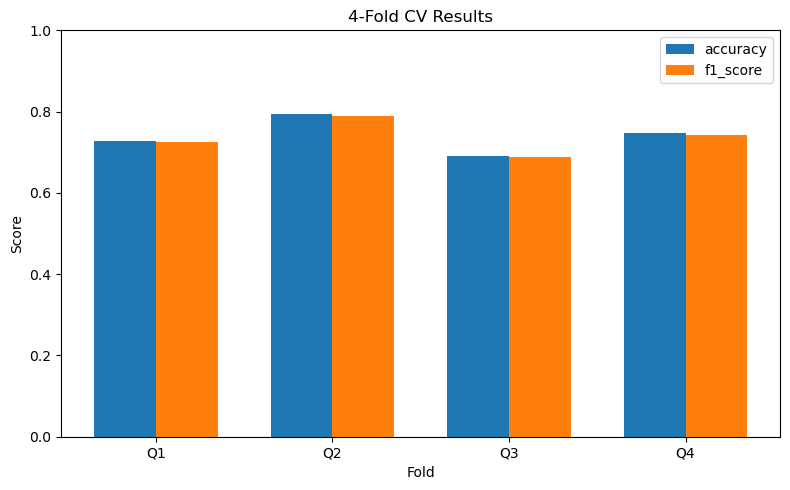

In [22]:
accuracies = []
f1_scores = []

for fold in FOLDS:
    print(f"\n— Fold: {fold} —")
    train_loader, test_loader = get_dataloaders_for_fold(fold)

    model = SimpleCNN(num_classes=NUM_CLASSES).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(EPOCHS):
        train_loss = train(model, train_loader, optimizer, criterion)
        print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {train_loss:.4f}")

 
    torch.save(model.state_dict(), "trained_model_50.pth")
    print("Model saved to trained_model_50.pth")

   
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_pred.extend(preds.cpu().numpy())
            y_true.extend(labels.cpu().numpy())

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average="weighted")
    accuracies.append(acc)
    f1_scores.append(f1)

    print(f"Accuracy: {acc:.4f}, F1-score: {f1:.4f}")
    print(classification_report(y_true, y_pred, target_names=["Non-Tumor", "Tumor", "Empty"]))


x = FOLDS
bar_width = 0.35
x_idx = np.arange(len(x))

plt.figure(figsize=(8, 5))
plt.bar(x_idx, accuracies, bar_width, label='accuracy')
plt.bar(x_idx + bar_width, f1_scores, bar_width, label='f1_score')
plt.xticks(x_idx + bar_width / 2, x)
plt.xlabel('Fold')
plt.ylabel('Score')
plt.title('4-Fold CV Results')
plt.ylim(0, 1.0)
plt.legend()
plt.tight_layout()
plt.show()

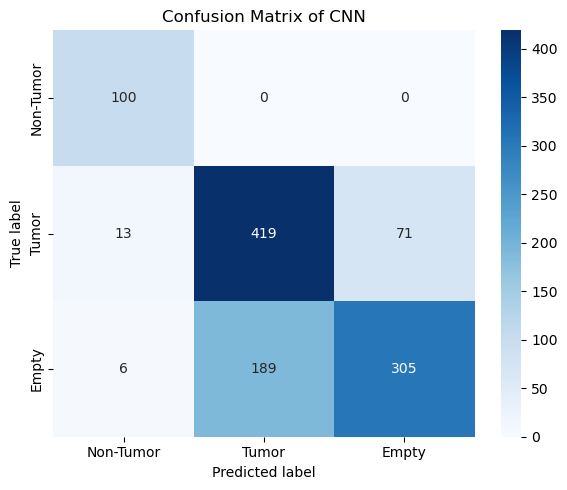

In [23]:
class_names = ["Non-Tumor", "Tumor", "Empty"]


cm = confusion_matrix(y_true, y_pred)


plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)

plt.title("Confusion Matrix of CNN")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()
plt.show()

In [25]:
import torch
import torch.nn.functional as F
import numpy as np
from PIL import Image
from tqdm import tqdm


model = SimpleCNN(num_classes=NUM_CLASSES).to(DEVICE)
model.load_state_dict(torch.load("trained_model_50.pth", map_location=DEVICE))
model.eval()


Image.MAX_IMAGE_PIXELS = None
big_img = Image.open(BIG_IMAGE_PATH)
width, height = big_img.size
print(f"Full image size: {width} x {height}")


n_rows = (height - TILE_SIZE) // STRIDE + 1
n_cols = (width - TILE_SIZE) // STRIDE + 1
print(f"Tiles: {n_rows} rows x {n_cols} cols")


def preprocess_tile(tile):
    tile = tile.resize((TILE_SIZE, TILE_SIZE))                    # Resize to model input
    tile = np.array(tile) / 255.0                                 # Normalize to [0, 1]
    tile = torch.tensor(tile, dtype=torch.float32).permute(2, 0, 1)  
    return tile.unsqueeze(0) 


tumor_tile_count = 0
total_tiles = 0


with tqdm(total=n_rows * n_cols, desc="Predicting on full image") as pbar:
    for i in range(n_rows):
        for j in range(n_cols):
            left = j * STRIDE
            upper = i * STRIDE
            right = left + TILE_SIZE
            lower = upper + TILE_SIZE

            try:
                tile = big_img.crop((left, upper, right, lower)).copy()
            except Exception as e:
                print(f"Skipping tile at ({left},{upper}) due to crop error: {e}")
                pbar.update(1)
                continue

            tile_tensor = preprocess_tile(tile).to(DEVICE)

            with torch.no_grad():
                output = model(tile_tensor)                     # raw logits
                probs = F.softmax(output, dim=1)[0]             # softmax vector
                pred_class = torch.argmax(probs).item()         

                
                region_label = 1 if pred_class == 0 else 0
                tumor_tile_count += region_label
                total_tiles += 1

            pbar.update(1)


if total_tiles > 0:
    tumor_ratio = tumor_tile_count / total_tiles * 100
    print(f"\nTiles predicted as Tumor: {tumor_tile_count}/{total_tiles}")
    print(f"Tumor Ratio in Full Image: {tumor_ratio:.2f}%")
else:
    print("No valid tiles processed.")

Full image size: 30786 x 24241
Tiles: 484 rows x 615 cols


Predicting on full image: 100%|██████████| 297660/297660 [06:31<00:00, 760.13it/s]


Tiles predicted as Tumor: 132010/297660
Tumor Ratio in Full Image: 44.35%
